In [58]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

1. Data Understanding and Cleaning

In [59]:
# Load Excel file 
df = pd.read_excel(
    "C:/Users/9272.IONEXCH/Project/RO Dignostics/RO-1 Data.xlsx",
    sheet_name="Sheet1",
    header=0   
)


1.1 Data Information

In [60]:
# See the original Data
df.head()

,Date,RO-1 Feed pH,RO-1 Feed EC\n(µs/cms),RO-1 Feed TDS (mg/l),RO-1 Feed TSS (mg/l),RO-1 Feed Turbidity\nNTU,RO-1 Feed COD (mg/l),RO-1 Feed BOD (mg/l),RO-1 Feed BOD:\nCOD\nRatio,RO-1 Feed NH3N (mg/l),...,RO-1 R TDS\n(mg/l),RO-1 R Total Hardnes,RO-1 R Ca Hardness,RO-1 R Total Alkalinity,RO-1 R COD\n(mg/l),RO 1 FEED PRESSURE\n,RO 1 Rej PRESSURE\n,RO-1 Feed FLOW (m3/hr),RO-1 Permeate FLOW (KL),RO-1 REJECT FLOW (KL)
0,2023-12-15,7.90,NaN,NaN,ND,0.3,NaN,NaN,NaN,NaN,...,6290.0,NaN,NaN,NaN,760.0,NaN,NaN,NaN,NaN,NaN
1,2023-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-17,7.70,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-18,7.65,NaN,NaN,ND,0.5,450.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-19,7.80,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        643 non-null    datetime64[ns]
 1   RO-1 Feed pH                482 non-null    float64       
 2   RO-1 Feed  EC
(µs/cms)      380 non-null    float64       
 3   RO-1 Feed  TDS (mg/l)       321 non-null    float64       
 4   RO-1 Feed  TSS (mg/l)       341 non-null    object        
 5   RO-1 Feed Turbidity
NTU     195 non-null    float64       
 6   RO-1 Feed  COD (mg/l)       439 non-null    float64       
 7   RO-1 Feed  BOD (mg/l)       85 non-null     object        
 8   RO-1 Feed BOD:
COD
Ratio    28 non-null     float64       
 9   RO-1 Feed NH3N (mg/l)       218 non-null    float64       
 10  RO-1 Feed Zinc (mg/l)       111 non-null    float64       
 11  RO-1 Feed Total Hardness    175 non-null    float64       

We have 38 columns out of which 6 are stored as object even though most of them should be numeric (e.g., RO-1 Feed TSS, BOD, PO4, COD, hardness values). and 1 Datetime column.

1.2 Logging Setup

In [62]:
# 1. Import and setup 
# We use Python’s built-in logging.We try to import python-json-logger (extra library). If it’s not installed, we fall back to our own formatter.
import logging, sys, json
from datetime import datetime

try:
    from pythonjsonlogger import jsonlogger
    JSONLOGGER_AVAILABLE = True
except Exception:
    JSONLOGGER_AVAILABLE = False

#2. Fallback json formatter
#Converts each log record into a Python dict (payload).
#Adds timestamp, level, message, code location.
#If we pass extra fields (extra={"step": "logging_init"}), they’re added under "extra".
#Dumps everything as a JSON string.
#This ensures that even without python-json-logger, we always get structured JSON logs.

class FallbackJsonFormatter(logging.Formatter):
    def format(self, record):
        payload = {
            "timestamp": datetime.utcfromtimestamp(record.created).isoformat() + "Z",
            "level": record.levelname,
            "logger": record.name,
            "message": record.getMessage(),
            "module": record.module,
            "funcName": record.funcName,
            "lineNo": record.lineno,
        }
        if record.exc_info:
            payload["exc_info"] = self.formatException(record.exc_info)
        # include extra attributes if present
        extras = {k:v for k,v in record.__dict__.items() if k not in logging.LogRecord.__dict__}
        if extras:
            payload["extra"] = extras
        return json.dumps(payload)

#3. Main Setup Fuction:
#Creates a logger named "ro1_pipeline".Sets the level (INFO, DEBUG, etc.).
#Attaches a handler: File handler if we provide a path (your case: ro1_pipeline.json).Otherwise it prints to console.
def setup_logging(level=logging.INFO, out_file=None):
    logger = logging.getLogger("ro1_pipeline")
    logger.setLevel(level)
    # remove any existing handlers to avoid duplicated logs
    if logger.handlers:
        logger.handlers = []
    # choose handler (file or stdout)
    handler = logging.FileHandler(out_file, encoding="utf-8") if out_file else logging.StreamHandler(sys.stdout)

# 4. Formatter Choice:
#If python-json-logger is installed → use its JSON formatter with standard logging tokens (%(asctime)s, etc.).Otherwise → use our fallback JSON formatter.

    if JSONLOGGER_AVAILABLE:
        try:
            fmt = '%(asctime)s %(levelname)s %(name)s %(module)s %(funcName)s %(lineno)d %(message)s'
            jf = jsonlogger.JsonFormatter(fmt)
            handler.setFormatter(jf)
        except Exception as e:
            # If anything goes wrong, fall back to our simple JSON formatter
            handler.setFormatter(FallbackJsonFormatter())
            logger = logging.getLogger("ro1_pipeline")
            logger.addHandler(handler)
            logger.warning("jsonlogger available but failed to initialize; using fallback formatter", extra={"error": str(e)})
            return logger
    else:
        handler.setFormatter(FallbackJsonFormatter())
        
# 5. Return Logger: Adds the handler to the logger and returns it.

    logger.addHandler(handler)
    return logger

# 6. Usage: Writes a JSON log line,set our absolute path (Windows)
logger = setup_logging(level=logging.INFO, out_file=r"C:/Users/9272.IONEXCH/Project/RO Dignostics/ro1_pipeline.json")
logger.info("Logging setup complete", extra={"step":"logging_init"})


1.3 Clean column names + convert obvious object columns to numeric

In [63]:
# 1. normalize column names:
#Replaced newline characters with _, removed non-alphanumeric characters (like (, ), µ, /), and converted spaces to underscores.
#Example: "RO-1 Feed Turbidity\nNTU" → RO1_Feed_Turbidity_NTU.
#We require clean, consistent column names safe for pipelines and file systems.

import re
def clean_column(name: str) -> str:
    name = str(name).replace("\n", "_")
    name = re.sub(r"[^\w\s]", "", name)  # remove special chars
    name = re.sub(r"\s+", "_", name)     # spaces -> underscore
    return name.strip("_")

df.columns = [clean_column(c) for c in df.columns]
logger.info("Column names cleaned", extra={"columns": list(df.columns)})

# 2. Convert object columns to numeric where possible:
# Found all columns with dtype object and attempted to convert each to numeric.
# pd.to_numeric(..., errors='coerce') converts valid numeric-like strings to numbers and turns invalid entries (like "ND", "<5", "abc") into NaN.
# For each column we logged how many non-null values existed before and after conversion — that helps find columns where many values failed to convert.

obj_cols = df.select_dtypes(include="object").columns.tolist()
for col in obj_cols:
    before_non_null = df[col].notna().sum()
    df[col] = pd.to_numeric(df[col], errors="coerce")
    after_non_null = df[col].notna().sum()
    logger.debug(f"Converted {col} to numeric", extra={"before_non_null": before_non_null, "after_non_null": after_non_null})

# 3. Ensure Date is datetime
#Ensured the Date column is datetime64[ns]. Any non-parseable dates become NaT (null datetime).Logged how many date rows failed to parse.

if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    logger.info("Date column parsed to datetime", extra={"null_dates": int(df['Date'].isna().sum())})

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       643 non-null    datetime64[ns]
 1   RO1_Feed_pH                482 non-null    float64       
 2   RO1_Feed_EC_µscms          380 non-null    float64       
 3   RO1_Feed_TDS_mgl           321 non-null    float64       
 4   RO1_Feed_TSS_mgl           316 non-null    float64       
 5   RO1_Feed_Turbidity_NTU     195 non-null    float64       
 6   RO1_Feed_COD_mgl           439 non-null    float64       
 7   RO1_Feed_BOD_mgl           56 non-null     float64       
 8   RO1_Feed_BOD_COD_Ratio     28 non-null     float64       
 9   RO1_Feed_NH3N_mgl          218 non-null    float64       
 10  RO1_Feed_Zinc_mgl          111 non-null    float64       
 11  RO1_Feed_Total_Hardness    175 non-null    float64       
 12  RO1_Feed

Insights:

643 rows × 38 columns (same as original).
All columns are now either float64 (37 columns) or datetime64[ns] (the Date column).
Non-numeric text values (ND, <5, etc.) have been replaced with NaN.

Missing Values:Some columns are extremely sparse: RO1_R_SDI: only 4 non-null values → 99% missing. RO1_Feed_BOD_COD_Ratio: 28 values (~4% filled).
RO1_Feed_BOD_mgl: 56 values (~9% filled).RO1_P_Total_Hardnes (72 values), RO1_P_Ca_Hardness (67), etc. → all <15% filled.

Moderate Missing: Columns like RO1_Feed_TDS_mgl (321 filled), RO1_P_TDS_mgl (135 filled), RO1_R_TDS_mgl (217 filled).These are important operational parameters, so instead of dropping, we will impute.
Same for Flows and Pressures (~301 values each = ~47% filled). These are critical, so we keep and impute.

Well-Populated Columns

RO1_Feed_pH: 482 filled (~75%).

RO1_P_PH: 402 filled (~62%).

RO1_R_PH: 392 filled (~61%).

These columns are usable with imputation.

1.4 Missingness Table and Visualization

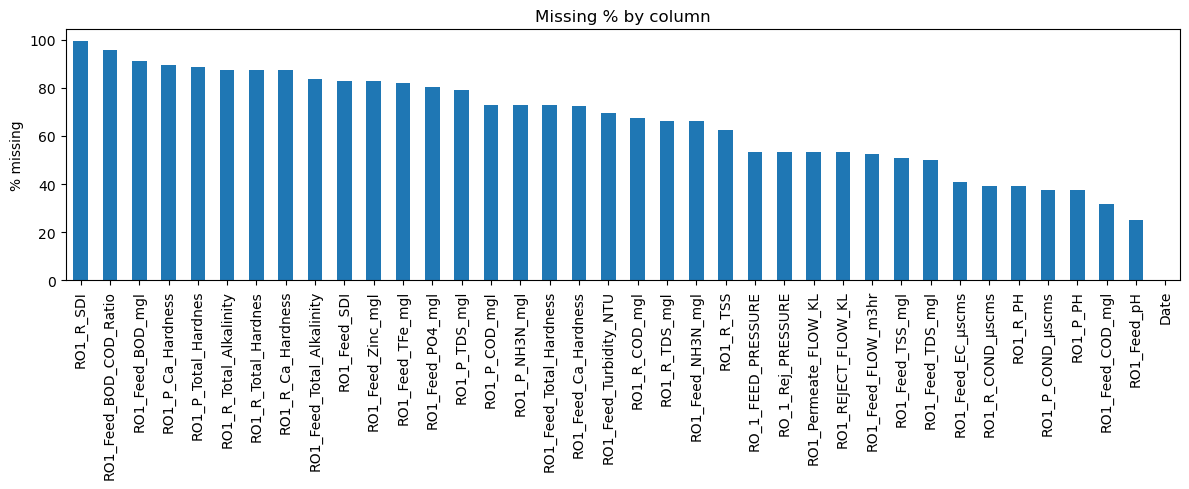

In [64]:
# Cell 3 — missingness summary and bar plot
missing = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": df.isna().mean() * 100,
    "dtype": df.dtypes,
    "unique_count": df.nunique(dropna=True)
}).sort_values("missing_percent", ascending=False)

# save summary
missing.to_csv("C:/Users/9272.IONEXCH/Project/RO Dignostics/ro1_missing_summary.csv")

# display top missing columns
missing.head(30)

# bar plot
plt.figure(figsize=(12,5))
missing["missing_percent"].plot(kind="bar")
plt.ylabel("% missing")
plt.title("Missing % by column")
plt.tight_layout()
plt.show()


Insights: 
As per the bar chart we have seen the columns where the missing vlaues are more than 80% are: RO1_R_SDI,RO1_Feed_BOD_COD_Ratio,RO1_Feed_BOD_mgl, RO1_P_Ca_Hardness, RO1_P_Total_Hardnes, RO1_R_Total_Alkalinity, RO1_R_Total_Hardnes, RO1_R_Ca_Hardness, RO1_Feed_Total_Alkalinity, RO1_Feed_SDI, RO1_Feed_Zinc_mgl,RO1_Feed_TFe_mgl,RO1_Feed_PO4_mgl
As per our domain exerience we will decide which columns are need to keep though the data is less, as its contributing in our final results. like Feed_SDI is important parameter to ensure the RO feed water quality. hardness is again important factor is for feed water quality. 
Zn, Alkalinity, Fe etc we can remove as we already have enough parameters to conclude. 

1.5 Show the list of columns that would be dropped (>90% missing)

In [65]:
# list columns > 90% missing (manual review)
threshold = 90.0
cols_to_drop = missing[missing["missing_percent"] > threshold].index.tolist()
print("Columns with >90% missing (would be dropped):")
for c in cols_to_drop:
    print(f" - {c} ({missing.loc[c,'missing_percent']:.1f}% missing)")

Columns with >90% missing (would be dropped):
 - RO1_R_SDI (99.4% missing)
 - RO1_Feed_BOD_COD_Ratio (95.6% missing)
 - RO1_Feed_BOD_mgl (91.3% missing)


In [66]:
# drop columns > 90% missing and log action
threshold = 90.0
cols_to_drop = missing[missing["missing_percent"] > threshold].index.tolist()
logger.info("Dropping high-missing columns", extra={"threshold_percent": threshold, "columns_dropped": cols_to_drop})
df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns. New shape: {df.shape}")

Dropped 3 columns. New shape: (643, 35)


In [67]:
#Domain-aware imputation 

from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Ensure Date is index for time interpolation
# Required so interpolate(method="time") knows the actual time spacing and does sensible interpolation.

def ensure_datetime_index(df, date_candidates=["Date", "DATE", "date"]):
    """
    Ensure df is sorted and indexed by a datetime index.
    Returns (df_with_datetime_index, original_index_was_date_bool).
    """
    # If index is already datetime, just sort_index and return
    if hasattr(df.index, "dtype") and str(df.index.dtype).startswith("datetime"):
        df = df.sort_index()
        return df, True

    # If a Date-like column exists, use the first candidate found
    for cand in date_candidates:
        if cand in df.columns:
            df[cand] = pd.to_datetime(df[cand], errors="coerce")
            if df[cand].isna().all():
                continue
            df = df.sort_values(cand).set_index(cand)
            return df, True

    # Try to locate any column with datetime dtype
    datetime_cols = [c for c in df.columns if str(df[c].dtype).startswith("datetime")]
    if datetime_cols:
        cand = datetime_cols[0]
        df = df.sort_values(cand).set_index(cand)
        return df, True

    # Try to infer datetime-like columns by parsing - pick the best candidate
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce")
            non_null = parsed.notna().sum()
            if non_null > 0.1 * len(df):  # at least 10% parsed as dates
                df[c] = parsed
                df = df.sort_values(c).set_index(c)
                return df, True
        except Exception:
            continue

    # If all fails, return original and flag False
    return df, False

# Ensure datetime index (safe)
df, has_date = ensure_datetime_index(df)
if not has_date:
    raise KeyError("No Date column or datetime index found. Please ensure your DataFrame has a Date column or datetime index before imputation.")

# 2. standard_impute(df, low_pct=30.0, med_pct=80.0):
# Iterates numeric columns and checks missing percentage.
# Flows / Pressures: treated specially — they are time-continuous process signals, so:interpolate(method='time') reconstructs missing samples based on time series behavior.
# ffill() & bfill() fill any endpoints.
# Columns with ≤ 30% missing: attempt time interpolation first (keeps trend), then fill any leftovers with median.
# 30% < missing ≤ 80%: too many gaps for reliable interpolation → median imputation is more robust.
# >80%: not handled here (domain decision whether to keep/drop).
# impute_log lists which columns used which strategy 

def standard_impute(df, low_pct=30.0, med_pct=80.0):
    impute_log = {"interpolated": [], "median_imputed": [], "ffill_bfill": []}
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    for col in num_cols:
        pct_missing = df[col].isna().mean() * 100
        if pct_missing == 0:
            continue
        # flows/pressures: interpolate + ffill/bfill
        if ("FLOW" in col.upper()) or ("PRESSURE" in col.upper()):
            try:
                df[col] = df[col].interpolate(method="time", limit_direction="both")
            except Exception:
                df[col] = df[col].interpolate(limit_direction="both")
            df[col] = df[col].ffill().bfill()
            impute_log["ffill_bfill"].append(col)
        elif pct_missing <= low_pct:
            try:
                df[col] = df[col].interpolate(method="time", limit_direction="both")
            except Exception:
                df[col] = df[col].interpolate(limit_direction="both")
            if df[col].isna().sum() > 0:
                df[col] = df[col].fillna(df[col].median())
            impute_log["interpolated"].append(col)
        elif pct_missing <= med_pct:
            df[col] = df[col].fillna(df[col].median())
            impute_log["median_imputed"].append(col)
        # >80% missing -> handled separately by domain decision
    return df, impute_log

df, impute_log_std = standard_impute(df)

# 3. regression_impute(df, target_col, feature_cols):
# Finds rows where the target (e.g., RO1_Feed_Total_Hardness) and predictors (TDS, EC, pH) are all present
# uses those rows to train a simple LinearRegression.
# Predicts target values where the target is missing but the predictors are available.
# Useful because hardness correlates with TDS/EC (domain fact). Regression uses that relationship to impute plausible values.

def regression_impute(df, target_col, feature_cols):
    # require at least some rows where target and features are present
    available = df.dropna(subset=[target_col] + feature_cols)
    if available.empty or available[target_col].nunique() < 2:
        print(f"⚠️ Not enough data to train regression for {target_col}")
        return df

    X_train = available[feature_cols]
    y_train = available[target_col]
    model = LinearRegression()
    model.fit(X_train, y_train)

    # optional diagnostics (comment out if noisy)
    try:
        from sklearn.metrics import r2_score, mean_squared_error
        y_pred_train = model.predict(X_train)
        print(f"{target_col} — Train R2: {r2_score(y_train, y_pred_train):.4f}, RMSE: {mean_squared_error(y_train, y_pred_train, squared=False):.3f}")
    except Exception:
        pass

    # Predict where target is missing but features exist
    missing_mask = df[target_col].isna() & df[feature_cols].notna().all(axis=1)
    if missing_mask.any():
        df.loc[missing_mask, target_col] = model.predict(df.loc[missing_mask, feature_cols])
        print(f"✅ Filled {missing_mask.sum()} missing values in {target_col} using regression.")

    return df

# 4. Choose predictors (we can adjust as per domain knowledge)
#Iterates important targets and attempts regression-based fill using the available predictors.

predictors = ["RO1_Feed_TDS_mgl", "RO1_Feed_EC_µscms", "RO1_Feed_pH"]
predictors = [p for p in predictors if p in df.columns]  # keep only existing

for target in ["RO1_Feed_Total_Hardness", "RO1_Feed_Ca_Hardness", "RO1_Feed_SDI"]:
    if target in df.columns:
        df = regression_impute(df, target, predictors)

# Reset index back to have Date as a column (if you want)
df = df.reset_index()

logger.info("Domain-aware imputation complete", extra={"standard_impute": impute_log_std})


RO1_Feed_Total_Hardness — Train R2: 0.2229, RMSE: 682.887
RO1_Feed_Ca_Hardness — Train R2: 0.2252, RMSE: 564.095
RO1_Feed_SDI — Train R2: 0.0011, RMSE: 0.660
✅ Filled 534 missing values in RO1_Feed_SDI using regression.


R2 are very weak and RMSE is high for all (Total Hardness, Ca and SDI).Hardness and TDS/EC correlation is normally stronger in RO systems.But our dataset is sparse (only ~170 rows with hardness values).That limited data + noise → weak regression.
SDI is a composite fouling index; it depends on turbidity, colloids, organics. TDS/EC/pH don’t capture it. That’s why R² ≈ 0.

Since our dataset is limited and you want to develop a predictive model, the main strategy should be:Keeping all domain-critical columns (even if filled artificially).Clearly flag which values were imputed.
Use imputed values to train models, but when presenting results, clarify that part of the data is synthetic.

In [68]:

display(df[["RO_1_FEED_PRESSURE","RO_1_Rej_PRESSURE","RO1_Feed_FLOW_m3hr","RO1_Permeate_FLOW_KL","RO1_REJECT_FLOW_KL"]].head(10))


,RO_1_FEED_PRESSURE,RO_1_Rej_PRESSURE,RO1_Feed_FLOW_m3hr,RO1_Permeate_FLOW_KL,RO1_REJECT_FLOW_KL
0,23.0,21.5,5.2,2.7,2.2
1,23.0,21.5,5.2,2.7,2.2
2,23.0,21.5,5.2,2.7,2.2
3,23.0,21.5,5.2,2.7,2.2
4,23.0,21.5,5.2,2.7,2.2
5,23.0,21.5,5.2,2.7,2.2
6,23.0,21.5,5.2,2.7,2.2
7,23.0,21.5,5.2,2.7,2.2
8,23.0,21.5,5.2,2.7,2.2
9,23.0,21.5,5.2,2.7,2.2


In [69]:
df.head()

,Date,RO1_Feed_pH,RO1_Feed_EC_µscms,RO1_Feed_TDS_mgl,RO1_Feed_TSS_mgl,RO1_Feed_Turbidity_NTU,RO1_Feed_COD_mgl,RO1_Feed_NH3N_mgl,RO1_Feed_Zinc_mgl,RO1_Feed_Total_Hardness,...,RO1_R_TDS_mgl,RO1_R_Total_Hardnes,RO1_R_Ca_Hardness,RO1_R_Total_Alkalinity,RO1_R_COD_mgl,RO_1_FEED_PRESSURE,RO_1_Rej_PRESSURE,RO1_Feed_FLOW_m3hr,RO1_Permeate_FLOW_KL,RO1_REJECT_FLOW_KL
0,2023-12-15,7.90,10810.0,7090.0,104.5,0.30,798.0,103.6,NaN,2000.0,...,6290.0,NaN,NaN,NaN,760.0,23.0,21.5,5.2,2.7,2.2
1,2023-12-16,7.80,10810.0,7090.0,104.5,0.98,798.0,103.6,NaN,2000.0,...,10750.0,NaN,NaN,NaN,1400.0,23.0,21.5,5.2,2.7,2.2
2,2023-12-17,7.70,10810.0,7090.0,104.5,0.70,798.0,103.6,NaN,2000.0,...,10750.0,NaN,NaN,NaN,1400.0,23.0,21.5,5.2,2.7,2.2
3,2023-12-18,7.65,10810.0,7090.0,104.5,0.50,450.0,103.6,NaN,2000.0,...,10750.0,NaN,NaN,NaN,1400.0,23.0,21.5,5.2,2.7,2.2
4,2023-12-19,7.80,10810.0,7090.0,104.5,0.80,798.0,103.6,NaN,2000.0,...,10750.0,NaN,NaN,NaN,1400.0,23.0,21.5,5.2,2.7,2.2


In [70]:
# verification
missing_after = df.isna().mean() * 100
missing_after = missing_after.sort_values(ascending=False)
missing_after[missing_after>0]  # show only columns still with missing (ideally none)
# Save final missing table
print("Missingness after imputation (top):")
print(missing_after.head(20))

Missingness after imputation (top):
RO1_P_Ca_Hardness            89.580093
RO1_P_Total_Hardnes          88.802488
RO1_R_Total_Alkalinity       87.402799
RO1_R_Ca_Hardness            87.247278
RO1_R_Total_Hardnes          87.247278
RO1_Feed_Total_Alkalinity    83.825816
RO1_Feed_Zinc_mgl            82.737170
RO1_Feed_TFe_mgl             82.115086
RO1_Feed_PO4_mgl             80.404355
RO_1_FEED_PRESSURE            0.000000
RO1_R_COD_mgl                 0.000000
RO_1_Rej_PRESSURE             0.000000
RO1_Feed_FLOW_m3hr            0.000000
RO1_Permeate_FLOW_KL          0.000000
RO1_R_TDS_mgl                 0.000000
RO1_R_TSS                     0.000000
RO1_R_COND_µscms              0.000000
RO1_R_PH                      0.000000
RO1_P_NH3N_mgl                0.000000
Date                          0.000000
dtype: float64


In [71]:
# Save cleaned dataframe to Excel
output_path = "C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/RO_Data_cleaned.xlsx"
df.to_excel(output_path, index=False)

print(f"✅ Cleaned file saved at: {output_path}")

✅ Cleaned file saved at: C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/RO_Data_cleaned.xlsx


Compute RO KPI's

In [72]:
 #KPI Computation & Rule-based Diagnosis
import numpy as np
import pandas as pd

# --- Ensure Date is index ---
if "Date" in df.columns:
    df = df.set_index("Date").sort_index()

# --- 1. Recovery % ---
if "RO1_Permeate_FLOW_KL" in df.columns and "RO1_Feed_FLOW_m3hr" in df.columns:
    df["Recovery_%"] = (df["RO1_Permeate_FLOW_KL"] / df["RO1_Feed_FLOW_m3hr"]) * 100

# --- 2. Salt Passage % and Salt Rejection % ---
if "RO1_P_TDS_mgl" in df.columns and "RO1_Feed_TDS_mgl" in df.columns:
    df["Salt_Passage_%"] = (df["RO1_P_TDS_mgl"] / df["RO1_Feed_TDS_mgl"]) * 100
    df["Salt_Rejection_%"] = 100 - df["Salt_Passage_%"]

# --- 3. Delta P (Pressure Drop) ---
if "RO_1_FEED_PRESSURE" in df.columns and "RO_1_Rej_PRESSURE" in df.columns:
    df["DeltaP_bar"] = df["RO_1_FEED_PRESSURE"] - df["RO_1_Rej_PRESSURE"]

# --- 4. Temperature Correction Factor (if temp exists, else = 1) ---
B = 0.021   # correction factor
Tref = 25   # reference temp
if "Temperature" in df.columns:
    df["TCF"] = np.exp(B * (df["Temperature"] - Tref))
else:
    df["TCF"] = 1

# --- 5. Normalized Permeate Flow ---
if "RO1_Permeate_FLOW_KL" in df.columns:
    df["Norm_Permeate_Flow"] = df["RO1_Permeate_FLOW_KL"] / df["TCF"]

# --- 6. Normalized Salt Passage ---
if "Salt_Passage_%" in df.columns:
    df["NSP_%"] = df["Salt_Passage_%"] / df["TCF"]



Rule Based Diagnostic

In [73]:
# --- Rule-based diagnosis ---
def diagnose(row):
    issues = []
    if pd.notna(row.get("Salt_Rejection_%")) and row["Salt_Rejection_%"] < 95:
        issues.append("Membrane Damage or Scaling")
    if pd.notna(row.get("Recovery_%")) and row["Recovery_%"] > 75:
        issues.append("Risk of Scaling")
    if pd.notna(row.get("DeltaP_bar")) and row["DeltaP_bar"] > 2:
        issues.append("Fouling / Clogging")
    if pd.notna(row.get("Norm_Permeate_Flow")) and row["Norm_Permeate_Flow"] < 0.8 * df["Norm_Permeate_Flow"].median():
        issues.append("Flow Decline - Fouling/Compaction")
    return "; ".join(issues) if issues else "Normal"

df["Diagnosis"] = df.apply(diagnose, axis=1)

# --- Log step completion ---
logger.info("KPIs and Rule-based Diagnosis computed", 
            extra={"n_rows": len(df), 
                   "n_diagnosis_flags": int((df['Diagnosis'] != 'Normal').sum())})

print("✅ KPI computation & diagnosis done.")
print("Sample output:")
display(df[["Recovery_%", "Salt_Rejection_%", "DeltaP_bar", "Norm_Permeate_Flow", "Diagnosis"]].head(10))

✅ KPI computation & diagnosis done.
Sample output:


,Recovery_%,Salt_Rejection_%,DeltaP_bar,Norm_Permeate_Flow,Diagnosis
Date,,,,,
2023-12-15,51.923077,97.884344,1.5,2.7,Normal
2023-12-16,51.923077,97.884344,1.5,2.7,Normal
2023-12-17,51.923077,97.884344,1.5,2.7,Normal
2023-12-18,51.923077,97.884344,1.5,2.7,Normal
2023-12-19,51.923077,97.884344,1.5,2.7,Normal
2023-12-20,51.923077,95.956873,1.5,2.7,Normal
2023-12-21,51.923077,95.384615,1.5,2.7,Normal
2023-12-22,51.923077,97.032641,1.5,2.7,Normal
2023-12-23,51.923077,95.731707,1.5,2.7,Normal


EDA- Visualization

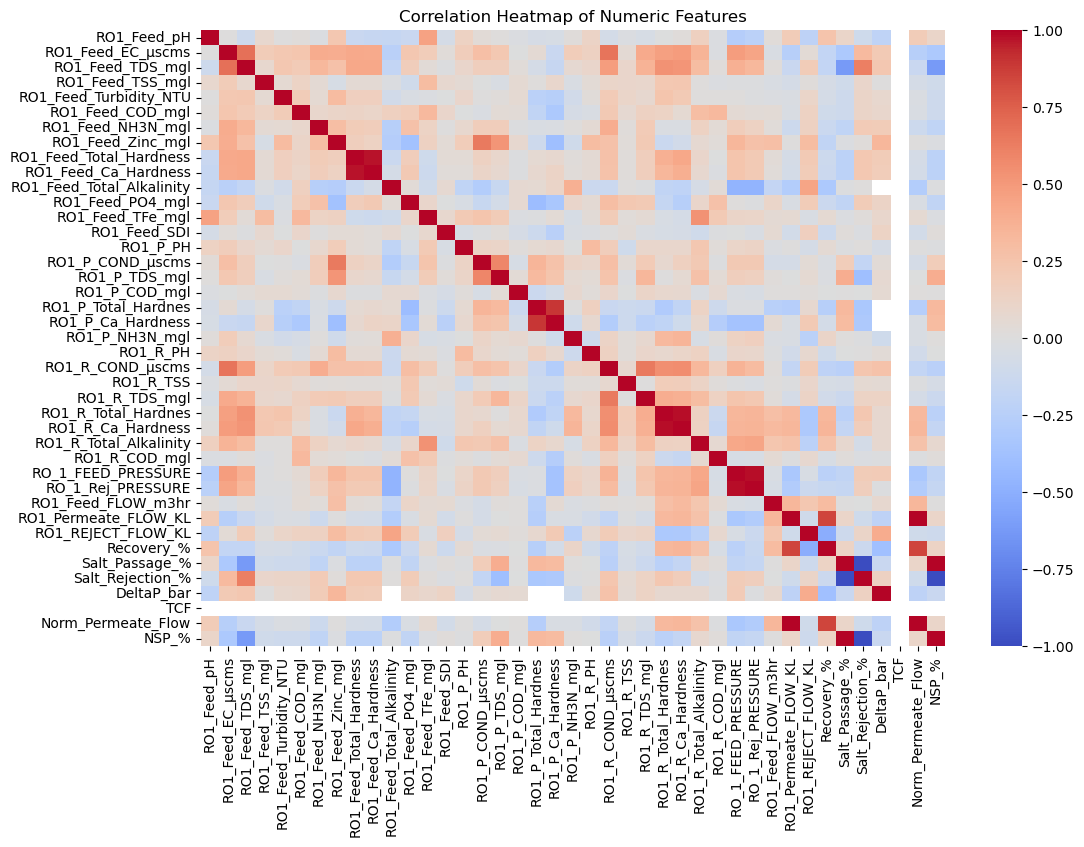

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))

# Only numeric columns
corr = df.select_dtypes(include="number").corr()

sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Key Insights:
1. Feewater Quality Parameters:
-->RO1_Feed_TDS_mgl ↔ RO1_Feed_Total_Hardness and RO1_Feed_Ca_Hardness → moderately strong positive correlation-Confirms the domain fact: higher TDS usually means more dissolved salts, hence higher hardness.
-->RO1_Feed_TDS_mgl ↔ RO1_Feed_EC_µscms → very high correlation (expected, since EC is proportional to ionic concentration/TDS).

2. KPI's shows logical correlation:
-->Recovery_% is moderately negatively correlated with RO1_REJECT_FLOW_KL (as recovery increases, reject decreases).
-->Recovery_% is positively correlated with RO1_Permeate_FLOW_KL (makes sense — higher recovery means more permeate).
-->Salt_Rejection_% is negatively correlated with Salt_Passage_% (they are complements).

3. ΔP (DeltaP_bar)
-->Shows mild correlation with RO1_Feed_FLOW_m3hr and reject/permeate flows.
-->In practice, rising ΔP is more about fouling than simple flow values, so a weaker correlation here is expected in lab data.

4. Norm_Permeate_Flow
-->Correlated with raw Permeate Flow (expected).
-->Also weak negative correlation with ΔP (as pressure drop increases, normalized flow tends to decrease → fouling/compaction effect).

5. SDI (Silt Density Index)
-->Has weak correlations with TDS and hardness in our dataset.
-->This suggests SDI is capturing something different (particulate/colloidal fouling risk) rather than dissolved salts- TSS
-->This is valuable — SDI adds orthogonal information to TDS/hardness.

6.Clusters visible 
-->The block of feed parameters (TDS, EC, Hardness, COD, etc.) forms one correlation cluster.
-->The block of KPIs (Recovery, Salt Rejection, NSP, Norm Flow) forms another cluster.
-->This separation is healthy: inputs and outputs are distinct but linked.

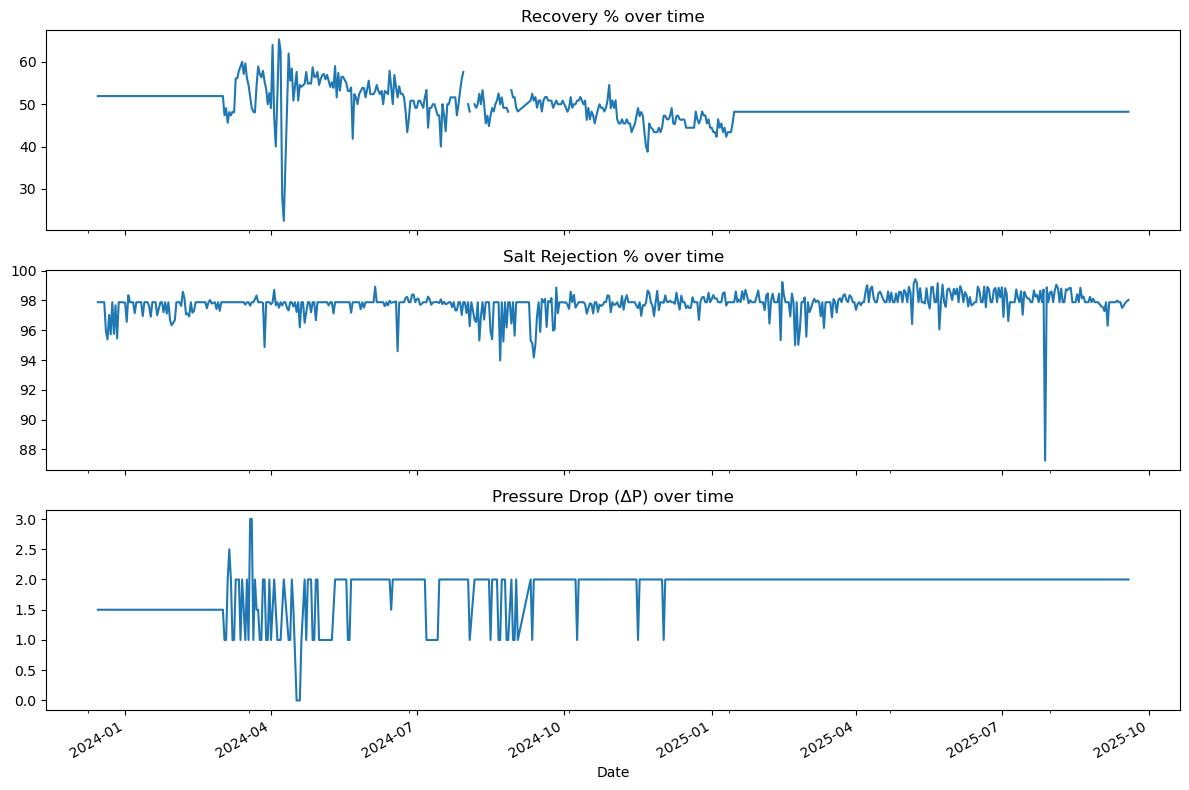

In [75]:
# KPI Time Series Subplot

fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True)

df['Recovery_%'].plot(ax=axs[0], title="Recovery % over time")
df['Salt_Rejection_%'].plot(ax=axs[1], title="Salt Rejection % over time")
df['DeltaP_bar'].plot(ax=axs[2], title="Pressure Drop (ΔP) over time")

plt.tight_layout()
plt.show()

-->Early 2024: System stable (Recovery ~52%, ΔP ~1.5 bar, Salt Rejection ~98%).
-->Mid 2024: Major instability — ΔP spikes, Recovery crashes, Salt Rejection dips → likely fouling/scaling event.
-->Late 2024–2025: System partially recovered, but baseline shifted (Recovery slightly lower, ΔP slightly higher).
-->Indicates irreversible stress on membranes — compaction, or incomplete cleaning.

In [76]:
# Feature Engineering:

In [77]:
#  Feature engineering + create one-step-ahead target
import numpy as np
import pandas as pd
from math import sin, cos, pi

# Ensure Date column is present and sorted
if "Date" in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
else:
    # if Date is index
    if hasattr(df.index, "dtype") and str(df.index.dtype).startswith("datetime"):
        df = df.reset_index().rename(columns={df.index.name: 'Date'})
    else:
        raise KeyError("Date column/index not found. Stop.")

# Working copy
d = df.copy()

# Time features
d['hour'] = d['Date'].dt.hour
d['day'] = d['Date'].dt.day
d['weekday'] = d['Date'].dt.weekday
d['month'] = d['Date'].dt.month

# Add simple seasonal encoding (yearly with period 365 if daily)
if len(d) > 365:
    period = 365.25
else:
    period = 7  # weekly seasonality fallback for short datasets
d['sin_yr'] = np.sin(2 * np.pi * (d['Date'].dt.dayofyear / period))
d['cos_yr'] = np.cos(2 * np.pi * (d['Date'].dt.dayofyear / period))

# Rolling means and lag features (use past values only)
roll_windows = [3, 6]   # samples; adjust to sampling frequency
for w in roll_windows:
    # Example: rolling of feed TDS and permeate flow
    if 'RO1_Feed_TDS_mgl' in d.columns:
        d[f'TDS_roll_{w}'] = d['RO1_Feed_TDS_mgl'].rolling(window=w, min_periods=1).mean()
    if 'RO1_Permeate_FLOW_KL' in d.columns:
        d[f'Permeate_roll_{w}'] = d['RO1_Permeate_FLOW_KL'].rolling(window=w, min_periods=1).mean()

# Lag features (past values only)
lags = [1, 3]
for L in lags:
    if 'RO1_Feed_TDS_mgl' in d.columns:
        d[f'TDS_lag_{L}'] = d['RO1_Feed_TDS_mgl'].shift(L)
    if 'RO1_Permeate_FLOW_KL' in d.columns:
        d[f'Permeate_lag_{L}'] = d['RO1_Permeate_FLOW_KL'].shift(L)
    if 'Recovery_%' in d.columns:
        d[f'Recovery_lag_{L}'] = d['Recovery_%'].shift(L)

# Interaction features
if 'RO1_Feed_TDS_mgl' in d.columns and 'RO1_Feed_Total_Hardness' in d.columns:
    d['TDS_x_Hardness'] = d['RO1_Feed_TDS_mgl'] * d['RO1_Feed_Total_Hardness']

# --- Target: one-step-ahead Recovery ---
if 'Recovery_%' not in d.columns:
    raise KeyError("Recovery_% not present — compute KPIs first.")
d['Recovery_next'] = d['Recovery_%'].shift(-1)   # target: next sample

# Drop last row (no next)
d = d.dropna(subset=['Recovery_next']).reset_index(drop=True)

# Basic feature list auto-detection (keep numeric, exclude target and date)
excluded = {'Date', 'Recovery_%', 'Recovery_next', 'Diagnosis'}
feature_cols = [c for c in d.select_dtypes(include=[np.number]).columns if c not in excluded]

# Quick log
logger.info("Feature engineering complete", extra={
    "n_rows": len(d), "n_features": len(feature_cols), "features_sample": feature_cols[:10]
})

# Show top rows and feature list
display(d[['Date','Recovery_%','Recovery_next'] + feature_cols[:6]].head(10))


,Date,Recovery_%,Recovery_next,RO1_Feed_pH,RO1_Feed_EC_µscms,RO1_Feed_TDS_mgl,RO1_Feed_TSS_mgl,RO1_Feed_Turbidity_NTU,RO1_Feed_COD_mgl
0,2023-12-15,51.923077,51.923077,7.900,10810.0,7090.0,104.5,0.30,798.0
1,2023-12-16,51.923077,51.923077,7.800,10810.0,7090.0,104.5,0.98,798.0
2,2023-12-17,51.923077,51.923077,7.700,10810.0,7090.0,104.5,0.70,798.0
3,2023-12-18,51.923077,51.923077,7.650,10810.0,7090.0,104.5,0.50,450.0
4,2023-12-19,51.923077,51.923077,7.800,10810.0,7090.0,104.5,0.80,798.0
5,2023-12-20,51.923077,51.923077,7.500,10810.0,3710.0,104.5,0.50,656.0
6,2023-12-21,51.923077,51.923077,7.510,10810.0,3250.0,104.5,0.40,640.0
7,2023-12-22,51.923077,51.923077,7.740,10810.0,3370.0,104.5,0.80,592.0
8,2023-12-23,51.923077,51.923077,7.760,10810.0,3280.0,104.5,0.90,448.0
9,2023-12-24,51.923077,51.923077,7.735,10810.0,7090.0,104.5,0.98,798.0


Our KPI Recovery_% tells how much of the feed becomes permeate at the same timestamp. But in forecasting / anomaly detection we don’t just want to 
explain today, we want to predict the future.So we create a new column:This shifts the Recovery_% values up by one row → so the “target” at time t is actually
the Recovery at time t+1.

Use in modeling

Features (X): all process variables at time t (flows, pressures, TDS, SDI, rolling averages, lags, etc.).

Target (y): Recovery_next, i.e. what Recovery will be in the next sample.

In [78]:
# Save engineered dataset (with lags, rolling, interaction, target)
output_path_d = "C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/RO_Data_FeatureSheet1_Model.xlsx"
d.to_excel(output_path_d, index=False)

print(f"✅ Engineered dataset saved at: {output_path_d}")

✅ Engineered dataset saved at: C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/RO_Data_FeatureSheet1_Model.xlsx


Train/Test split, baseline RandomForest, and CV summary

In [79]:
d.head()

,Date,RO1_Feed_pH,RO1_Feed_EC_µscms,RO1_Feed_TDS_mgl,RO1_Feed_TSS_mgl,RO1_Feed_Turbidity_NTU,RO1_Feed_COD_mgl,RO1_Feed_NH3N_mgl,RO1_Feed_Zinc_mgl,RO1_Feed_Total_Hardness,...,TDS_roll_6,Permeate_roll_6,TDS_lag_1,Permeate_lag_1,Recovery_lag_1,TDS_lag_3,Permeate_lag_3,Recovery_lag_3,TDS_x_Hardness,Recovery_next
0,2023-12-15,7.90,10810.0,7090.0,104.5,0.30,798.0,103.6,NaN,2000.0,...,7090.0,2.7,NaN,NaN,NaN,NaN,NaN,NaN,14180000.0,51.923077
1,2023-12-16,7.80,10810.0,7090.0,104.5,0.98,798.0,103.6,NaN,2000.0,...,7090.0,2.7,7090.0,2.7,51.923077,NaN,NaN,NaN,14180000.0,51.923077
2,2023-12-17,7.70,10810.0,7090.0,104.5,0.70,798.0,103.6,NaN,2000.0,...,7090.0,2.7,7090.0,2.7,51.923077,NaN,NaN,NaN,14180000.0,51.923077
3,2023-12-18,7.65,10810.0,7090.0,104.5,0.50,450.0,103.6,NaN,2000.0,...,7090.0,2.7,7090.0,2.7,51.923077,7090.0,2.7,51.923077,14180000.0,51.923077
4,2023-12-19,7.80,10810.0,7090.0,104.5,0.80,798.0,103.6,NaN,2000.0,...,7090.0,2.7,7090.0,2.7,51.923077,7090.0,2.7,51.923077,14180000.0,51.923077


In [89]:
import pandas as pd
import numpy as np

# Load engineered dataset
file_path = "C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/RO_Data_FeatureSheet1_Model.xlsx"
df = pd.read_excel(file_path)

# Replace inf with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows where target is missing
df = df.dropna(subset=["Recovery_next"])

print("✅ Cleaned dataset:", df.shape)
df[["Recovery_%","Recovery_next"]].describe()


✅ Cleaned dataset: (637, 61)


,Recovery_%,Recovery_next
count,634.000000,637.000000
mean,49.515965,49.518886
std,3.613055,3.618655
min,22.448980,22.448980
25%,48.214286,48.214286
50%,48.214286,48.214286
75%,51.923077,51.923077
max,65.306122,65.306122


In [90]:
# Exclude target + date + diagnosis columns
excluded = {"Date", "Recovery_%", "Recovery_next", "Diagnosis"}
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in excluded]

X = df[feature_cols]
y = df["Recovery_next"]

print("Number of features:", len(feature_cols))
print("Features sample:", feature_cols[:10])


Number of features: 57
Features sample: ['RO1_Feed_pH', 'RO1_Feed_EC_µscms', 'RO1_Feed_TDS_mgl', 'RO1_Feed_TSS_mgl', 'RO1_Feed_Turbidity_NTU', 'RO1_Feed_COD_mgl', 'RO1_Feed_NH3N_mgl', 'RO1_Feed_Zinc_mgl', 'RO1_Feed_Total_Hardness', 'RO1_Feed_Ca_Hardness']


In [91]:
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (509, 57) Test size: (128, 57)


In [92]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pipeline with imputer + RF
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 0.201
RMSE: 0.533
R²: -1408500281130096831210979328.000


In [93]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

scores_mae = cross_val_score(pipeline, X, y, cv=tscv, 
                             scoring="neg_mean_absolute_error", n_jobs=-1)
scores_rmse = cross_val_score(pipeline, X, y, cv=tscv, 
                              scoring="neg_root_mean_squared_error", n_jobs=-1)

print("MAE per fold:", -scores_mae)
print("Average MAE:", -scores_mae.mean())
print("RMSE per fold:", -scores_rmse)
print("Average RMSE:", -scores_rmse.mean())


MAE per fold: [4.55524883 2.30086253 2.65870309 1.28146664 0.2245901 ]
Average MAE: 2.2041742385435388
RMSE per fold: [6.43500176 2.76969333 3.40499686 1.62601601 0.64442741]
Average RMSE: 2.9760270738704677


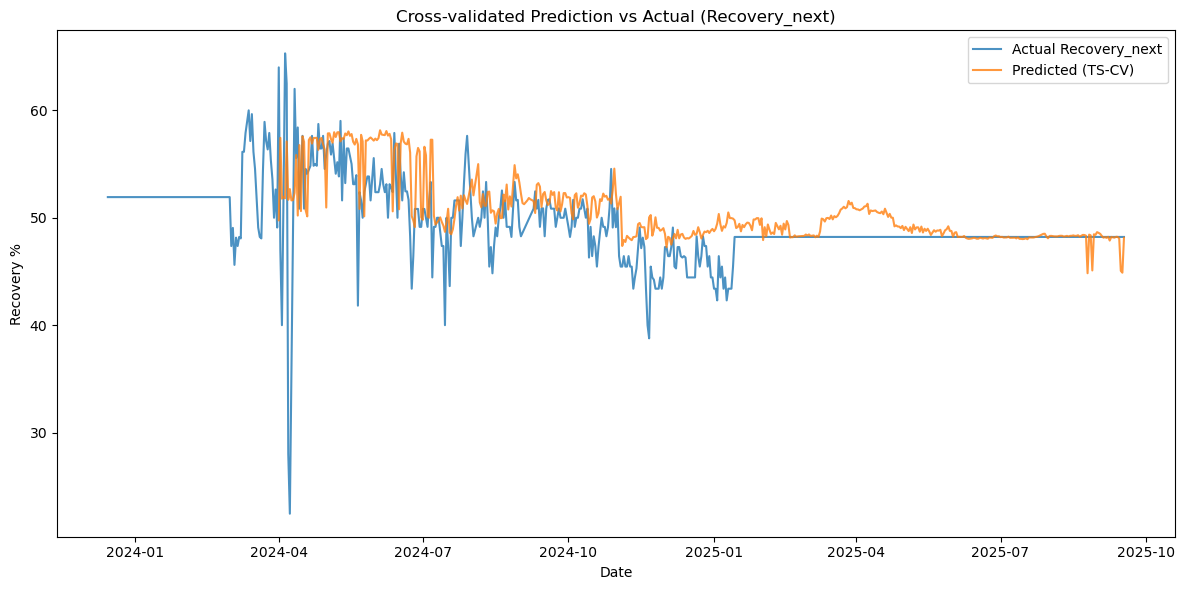

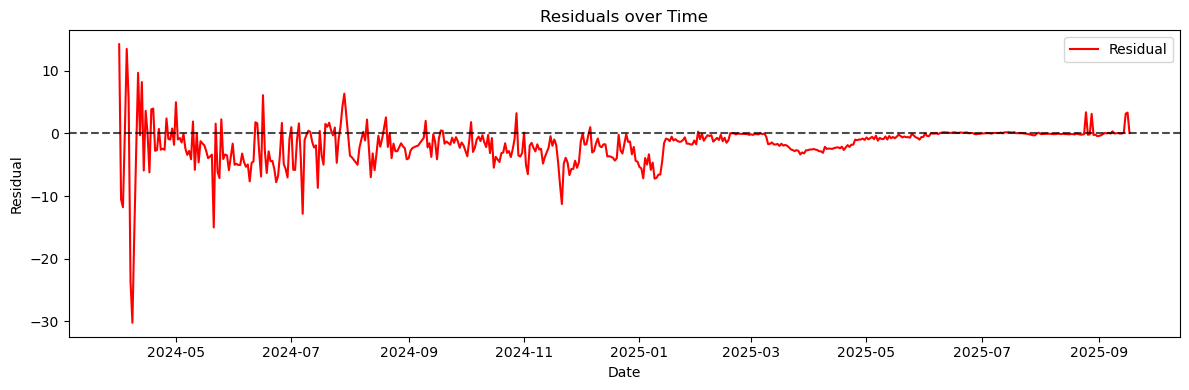

In [106]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
y_pred_cv = np.full(len(y), np.nan)  # placeholder

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    model = pipeline.fit(X_train, y_train)
    y_pred_cv[test_idx] = model.predict(X_test)

# Attach predictions to dataframe
df_cv = df.copy().reset_index(drop=True)
df_cv["Recovery_pred_cv"] = y_pred_cv

# --- Plot actual vs predicted ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_cv["Date"], df_cv["Recovery_next"], label="Actual Recovery_next", alpha=0.8)
plt.plot(df_cv["Date"], df_cv["Recovery_pred_cv"], label="Predicted (TS-CV)", alpha=0.8)
plt.xlabel("Date"); plt.ylabel("Recovery %")
plt.title("Cross-validated Prediction vs Actual (Recovery_next)")
plt.legend(); plt.tight_layout(); plt.show()

# Residuals
df_cv["residual"] = df_cv["Recovery_next"] - df_cv["Recovery_pred_cv"]
plt.figure(figsize=(12,4))
plt.plot(df_cv["Date"], df_cv["residual"], label="Residual", color="red")
plt.axhline(0, linestyle="--", color="black", alpha=0.7)
plt.xlabel("Date"); plt.ylabel("Residual")
plt.title("Residuals over Time")
plt.legend(); plt.tight_layout(); plt.show()


In [107]:
print("len(df_model) =", len(df))
print("len(X) =", len(X))
print("len(y) =", len(y))
print("len(y_pred_cv) =", len(y_pred_cv))

len(df_model) = 637
len(X) = 637
len(y) = 637
len(y_pred_cv) = 637


In [108]:
# A: attach cross-validated predictions, compute residuals, save results
import pandas as pd, numpy as np, os

# df_model, y_pred_cv already exist in your notebook (you confirmed lengths)
df_cv = df.reset_index(drop=True).copy()
df_cv["Recovery_pred_cv"] = y_pred_cv
df_cv["residual"] = df_cv["Recovery_next"] - df_cv["Recovery_pred_cv"]

out_cv_path = "C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/recovery_cv_results.csv"
df_cv.to_csv(out_cv_path, index=False)
print("✅ Saved CV results to:", out_cv_path)

# Quick sanity prints
print("Sample rows:")
display(df_cv[["Date","Recovery_next","Recovery_pred_cv","residual"]].head(10))
print("Residual summary:")
print(df_cv["residual"].describe())


✅ Saved CV results to: C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/recovery_cv_results.csv
Sample rows:


,Date,Recovery_next,Recovery_pred_cv,residual
0,2023-12-15,51.923077,NaN,NaN
1,2023-12-16,51.923077,NaN,NaN
2,2023-12-17,51.923077,NaN,NaN
3,2023-12-18,51.923077,NaN,NaN
4,2023-12-19,51.923077,NaN,NaN
5,2023-12-20,51.923077,NaN,NaN
6,2023-12-21,51.923077,NaN,NaN
7,2023-12-22,51.923077,NaN,NaN
8,2023-12-23,51.923077,NaN,NaN
9,2023-12-24,51.923077,NaN,NaN


Residual summary:
count    530.000000
mean      -1.664103
std        3.161702
min      -30.218550
25%       -2.798905
50%       -1.115553
75%       -0.068355
max       14.234588
Name: residual, dtype: float64


✅ Saved YAML rules to: C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/recovery_rules.yaml
✅ Saved priority CSV to: C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/recovery_cv_with_priority.csv
Flagged rows count: 307


,Date,Recovery_next,Recovery_pred_cv,residual,anomaly_flag_iso,anomaly_flag_thr,high_priority_combined,priority
107,2024-04-01,64.000000,49.765412,14.234588,1,1,1,high
108,2024-04-02,46.938776,57.437521,-10.498745,0,1,0,medium
109,2024-04-03,40.000000,51.775220,-11.775220,1,1,1,high
111,2024-04-05,65.306122,51.813236,13.492886,1,1,1,high
112,2024-04-06,62.500000,57.107641,5.392359,0,1,0,medium
113,2024-04-07,28.000000,51.679330,-23.679330,1,1,1,high
114,2024-04-08,22.448980,52.667529,-30.218550,1,1,1,high
115,2024-04-09,35.810811,51.614749,-15.803938,1,1,1,high
116,2024-04-10,48.993289,51.652905,-2.659616,0,1,0,medium
117,2024-04-11,62.000000,52.319170,9.680830,1,1,1,high


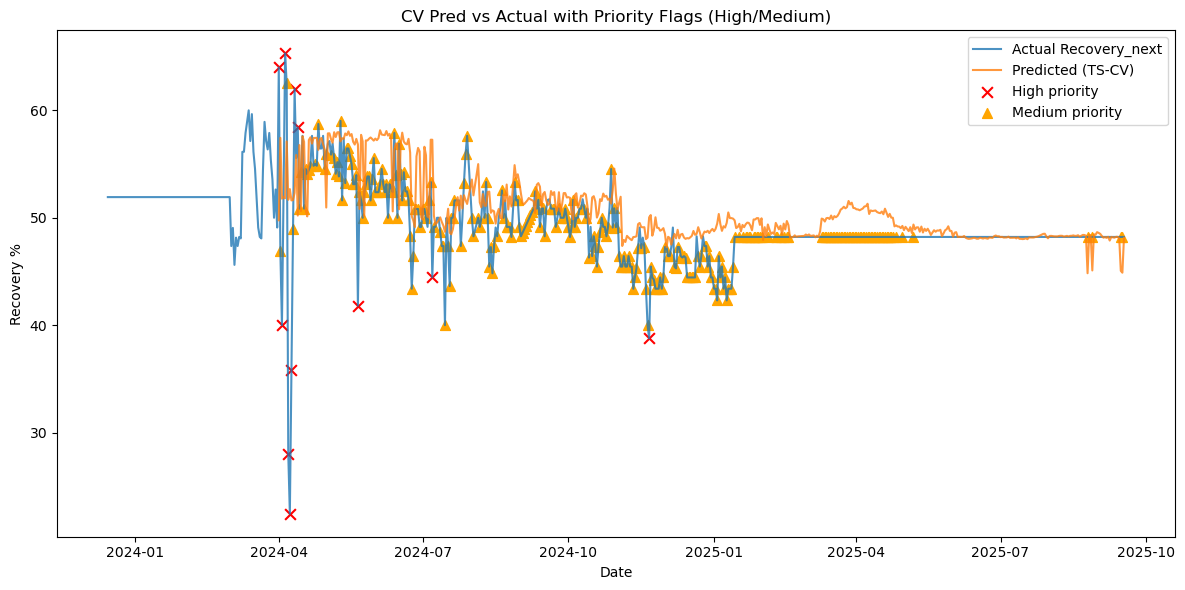

In [109]:
# B: anomaly flags (threshold + IsolationForest), YAML rules, priority assignment, plotting
import pandas as pd, numpy as np, yaml, ast, matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Load the saved CV results (optional — using df_cv from above is fine)
cv_path = "C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/recovery_cv_results.csv"
df_cv = pd.read_csv(cv_path, parse_dates=["Date"])

# 1) threshold flag
threshold = 1.0   # percent points, adjust if needed
df_cv["anomaly_flag_thr"] = (df_cv["residual"].abs() > threshold).astype(int)

# 2) IsolationForest on residuals (fit on all non-NaN residuals)
resid_train = df_cv["residual"].dropna().values.reshape(-1,1)
iso = IsolationForest(contamination=0.02, random_state=42)
iso.fit(resid_train)

# predict for all rows (fill NaN residuals with 0 just for scoring)
resid_all = df_cv["residual"].fillna(0).values.reshape(-1,1)
df_cv["anomaly_flag_iso"] = (iso.predict(resid_all) == -1).astype(int)
df_cv["anomaly_score_iso"] = iso.decision_function(resid_all)

# 3) combined high-priority flag
df_cv["high_priority_combined"] = ((df_cv["anomaly_flag_iso"] == 1) & (df_cv["residual"].abs() > threshold)).astype(int)

# 4) write YAML rules file
rules = {
    "rules": [
        {"name":"High - ISO + large residual",
         "condition":"high_priority_combined == 1",
         "action":{"type":"set_priority","parameters":{"code":1,"label":"high"}}},
        {"name":"Medium - ISO only",
         "condition":"anomaly_flag_iso == 1 and high_priority_combined == 0",
         "action":{"type":"set_priority","parameters":{"code":2,"label":"medium"}}},
        {"name":"Medium - threshold only",
         "condition":"anomaly_flag_thr == 1 and anomaly_flag_iso == 0",
         "action":{"type":"set_priority","parameters":{"code":2,"label":"medium"}}},
        {"name":"Low - normal",
         "condition":"true",
         "action":{"type":"set_priority","parameters":{"code":3,"label":"low"}}}
    ]
}
yaml_path = "C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/recovery_rules.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(rules, f)
print("✅ Saved YAML rules to:", yaml_path)

# 5) safe evaluator and rule application
ALLOWED_TYPES = (ast.Expression, ast.BoolOp, ast.UnaryOp, ast.BinOp, ast.Compare,
                 ast.Name, ast.Load, ast.Constant, ast.And, ast.Or, ast.Not,
                 ast.Eq, ast.NotEq, ast.Lt, ast.LtE, ast.Gt, ast.GtE)

def safe_eval_bool(expr: str, context: dict):
    parsed = ast.parse(expr, mode='eval')
    for node in ast.walk(parsed):
        if type(node) not in ALLOWED_TYPES:
            raise ValueError(f"Disallowed node: {type(node).__name__} in expr: {expr}")
    return bool(eval(compile(parsed, filename="<ast>", mode="eval"), {}, context))

def apply_rules_row(row):
    ctx = {
        "high_priority_combined": int(row.get("high_priority_combined", 0)),
        "anomaly_flag_iso": int(row.get("anomaly_flag_iso", 0)),
        "anomaly_flag_thr": int(row.get("anomaly_flag_thr", 0)),
        "residual_abs": float(abs(row.get("residual", 0)) if pd.notna(row.get("residual", None)) else 0)
    }
    for r in rules["rules"]:
        cond = r["condition"].replace("true","True")
        if safe_eval_bool(cond, ctx):
            act = r["action"]
            if act["type"] == "set_priority":
                return act["parameters"]["label"]
    return "low"

df_cv["priority"] = df_cv.apply(apply_rules_row, axis=1)

# 6) save priority CSV
out_priority = "C:/Users/9272.IONEXCH/Project/RO Diagnostics Model/RO-Diagnostic-Model-/recovery_cv_with_priority.csv"
df_cv.to_csv(out_priority, index=False)
print("✅ Saved priority CSV to:", out_priority)
print("Flagged rows count:", int((df_cv["priority"]!="low").sum()))

# 7) show sample flagged events
display(df_cv.loc[df_cv["priority"]!="low", ["Date","Recovery_next","Recovery_pred_cv","residual","anomaly_flag_iso","anomaly_flag_thr","high_priority_combined","priority"]].head(50))

# 8) plot Actual vs Predicted with priority markers
plt.figure(figsize=(12,6))
plt.plot(df_cv["Date"], df_cv["Recovery_next"], label="Actual Recovery_next", alpha=0.8)
plt.plot(df_cv["Date"], df_cv["Recovery_pred_cv"], label="Predicted (TS-CV)", alpha=0.8)
high = df_cv[df_cv["priority"]=="high"]
med  = df_cv[df_cv["priority"]=="medium"]
if len(high):
    plt.scatter(high["Date"], high["Recovery_next"], color="red", marker="x", s=60, label="High priority")
if len(med):
    plt.scatter(med["Date"], med["Recovery_next"], color="orange", marker="^", s=50, label="Medium priority")
plt.xlabel("Date"); plt.ylabel("Recovery %")
plt.title("CV Pred vs Actual with Priority Flags (High/Medium)")
plt.legend(); plt.tight_layout(); plt.show()


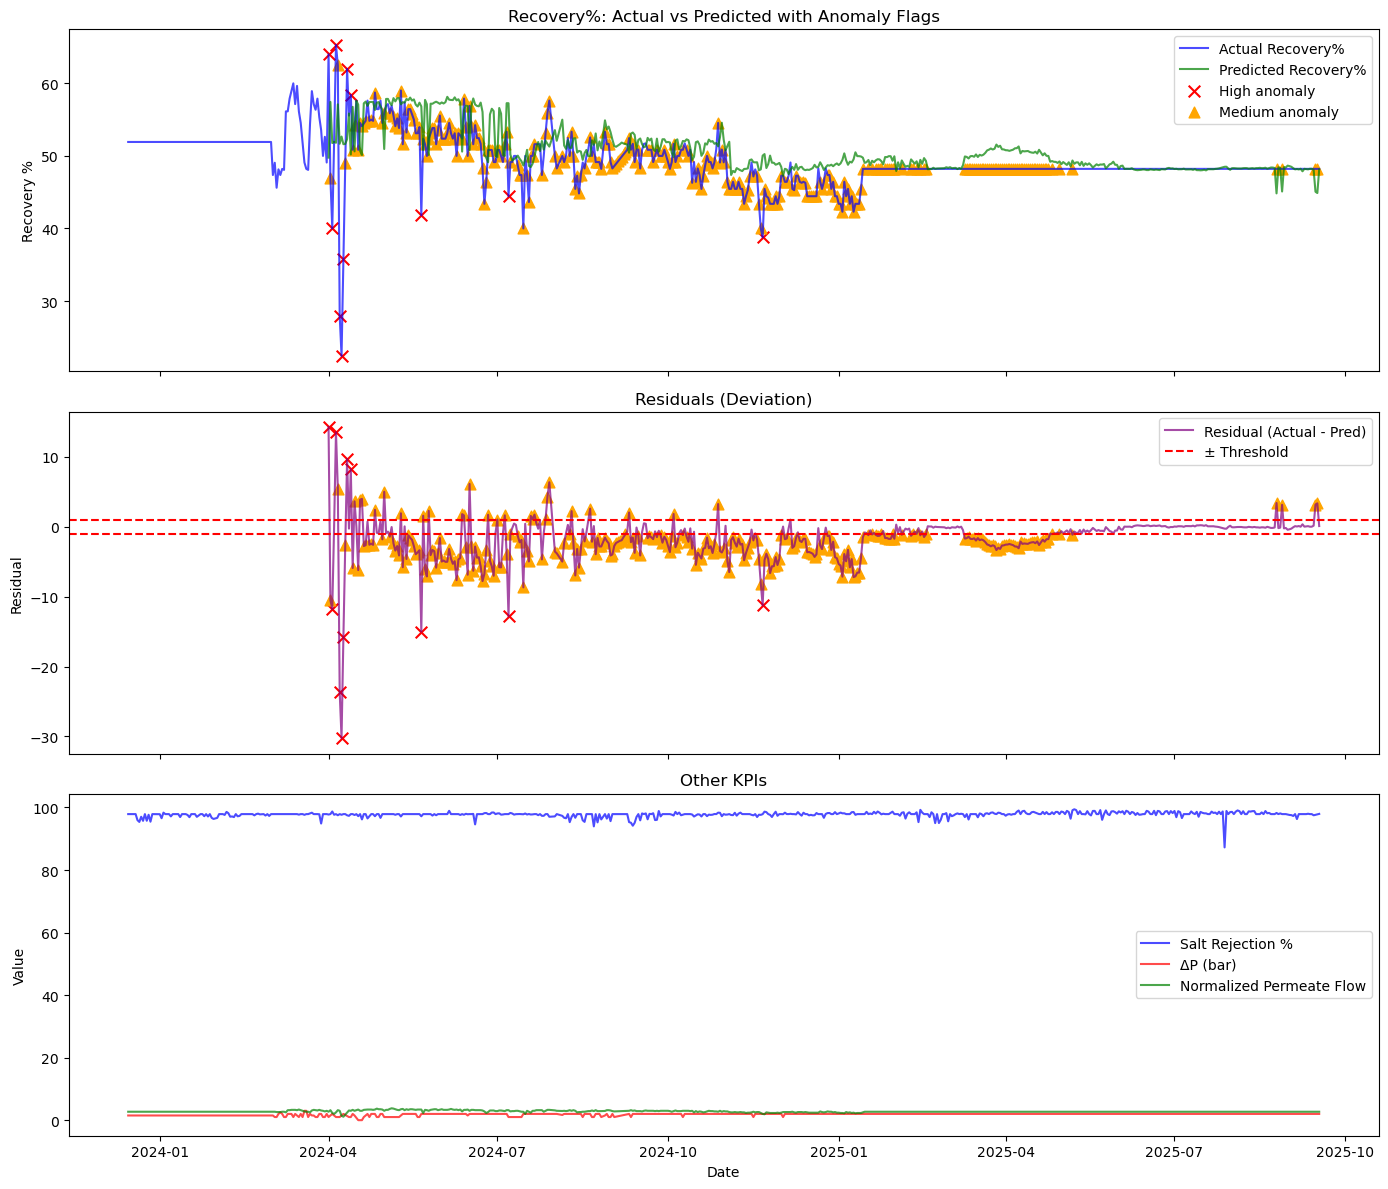

In [110]:
import matplotlib.pyplot as plt

# Ensure Date is datetime
df_cv["Date"] = pd.to_datetime(df_cv["Date"])

# Create figure
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# --- Panel 1: Recovery% actual vs predicted ---
axs[0].plot(df_cv["Date"], df_cv["Recovery_next"], label="Actual Recovery%", color="blue", alpha=0.7)
axs[0].plot(df_cv["Date"], df_cv["Recovery_pred_cv"], label="Predicted Recovery%", color="green", alpha=0.7)

# Mark anomalies
high = df_cv[df_cv["priority"]=="high"]
med  = df_cv[df_cv["priority"]=="medium"]
axs[0].scatter(high["Date"], high["Recovery_next"], color="red", marker="x", s=70, label="High anomaly")
axs[0].scatter(med["Date"], med["Recovery_next"], color="orange", marker="^", s=60, label="Medium anomaly")

axs[0].set_title("Recovery%: Actual vs Predicted with Anomaly Flags")
axs[0].set_ylabel("Recovery %")
axs[0].legend()

# --- Panel 2: Residuals ---
axs[1].plot(df_cv["Date"], df_cv["residual"], label="Residual (Actual - Pred)", color="purple", alpha=0.7)
axs[1].axhline(y=1.0, color="red", linestyle="--", label="± Threshold")
axs[1].axhline(y=-1.0, color="red", linestyle="--")

axs[1].scatter(high["Date"], high["residual"], color="red", marker="x", s=70)
axs[1].scatter(med["Date"], med["residual"], color="orange", marker="^", s=60)
axs[1].set_title("Residuals (Deviation)")
axs[1].set_ylabel("Residual")
axs[1].legend()

# --- Panel 3: Key KPIs ---
axs[2].plot(df_cv["Date"], df_cv["Salt_Rejection_%"], label="Salt Rejection %", color="blue", alpha=0.7)
axs[2].plot(df_cv["Date"], df_cv["DeltaP_bar"], label="ΔP (bar)", color="red", alpha=0.7)
axs[2].plot(df_cv["Date"], df_cv["Norm_Permeate_Flow"], label="Normalized Permeate Flow", color="green", alpha=0.7)

axs[2].set_title("Other KPIs")
axs[2].set_ylabel("Value")
axs[2].legend()

# --- Final formatting ---
plt.xlabel("Date")
plt.tight_layout()
plt.show()
